In this work, I used transfer learning on a pre-trained ResNet50 CNN model trained on the ImageNet dataset to perform classification for recognizing images of horses and camels using the dataset archive.zip (https://www.kaggle.com/akrsnv/horses-and-camels).

First, import dataset. Download the dataset archive.zip to local dir and extract it. Create a train_dataset for training and a test_dataset by using the keras.utils.image_dataset_from_directory utility.

Then, preprocessing, such as configure the dataset for performance, Use data augmentation, and rescale pixel values.

Next, create the training model based on the pre-models.

Last, testing and evalution, show the confusion matrix.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.metrics import confusion_matrix
import itertools

2023-01-28 01:36:51.164120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import dataset

Download the dataset archive.zip (https://www.kaggle.com/akrsnv/horses-and-camels) to local dir and extract it. Create a train_dataset for training and a test_dataset by using the keras.utils.image_dataset_from_directory utility.

In [ ]:
#import the local dataset archive.zip, which includes the images of horses and camels for training and testing.
local_file = os.path.abspath('./archive.zip')
path_to_zip = tf.keras.utils.get_file(local_file,'file://'+local_file)
PATH = os.path.join(os.path.dirname(path_to_zip), 'archive')
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
#creat a train_dataset for training by using the keras.utils.image_dataset_from_directory utility.
train_dataset = keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 360 files belonging to 2 classes.


2023-01-28 01:36:53.244214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 01:36:53.245366: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
#creat a test_dataset for testing by using the keras.utils.image_dataset_from_directory utility.
test_dataset = keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 40 files belonging to 2 classes.


Show the first nine images and labels from the training set.

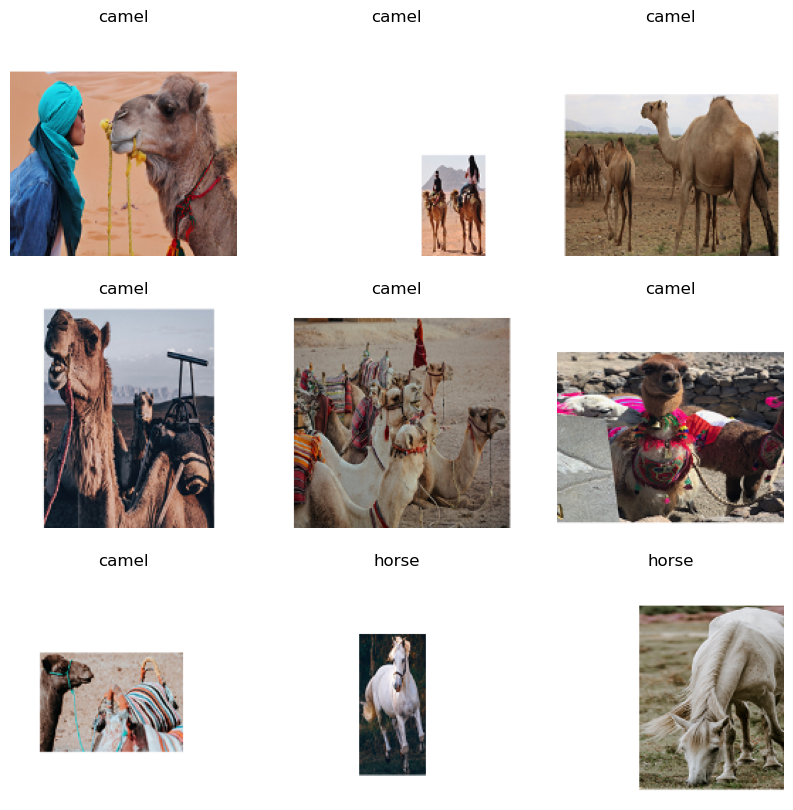

In [ ]:
class_names = train_dataset.class_names
#Show the first nine images and labels from the training set (train_dataset)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
#using buffered prefetching to load images from disk
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [ ]:
#use data augmentation,such as rotation and horizontal flipping, transformations to the training images.
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])

Repeatedly apply these layers to the same image and see the result.

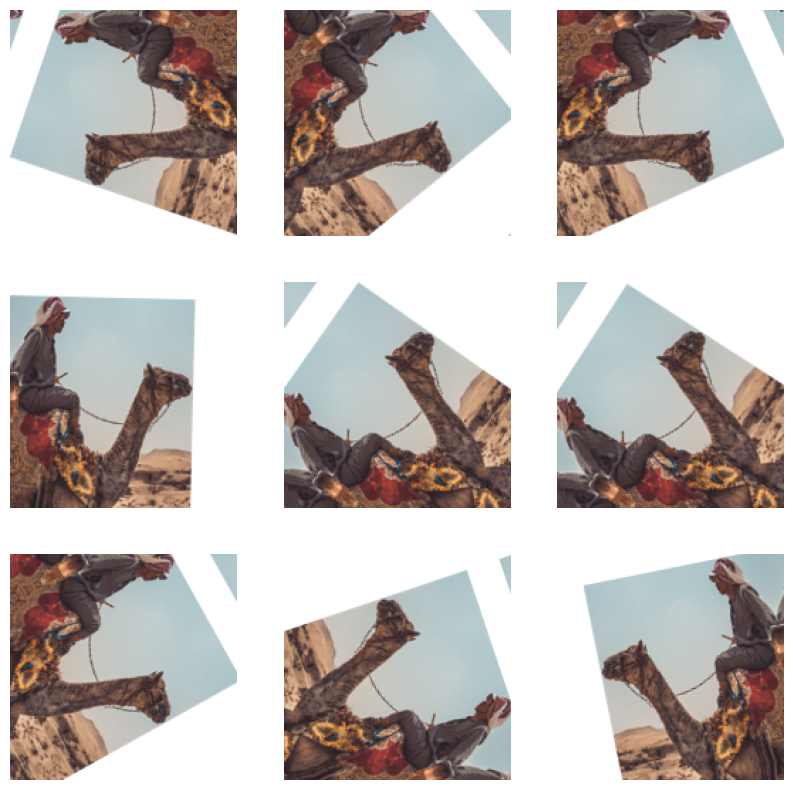

In [ ]:
#repeatedly apply these layers to the same image and show the result.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale pixel values

Using keras.applications.MobileNetV2 as the base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in the images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
#Using keras.applications.MobileNetV2 as the base model
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
#Rescale pixel values from [0, 255] to [-1, 1]
rescale = keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from the pre-trained convnets

Create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify horses and camels from our specific dataset.

A MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2, specifying the include_top=False argument.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Convert the feature extractor

In [ ]:
#This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Build the model from base model

Instantiate a base model with pre-trained weights.

In [ ]:
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training
base_model.trainable = False
# Look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Add a classification head

In [ ]:
#using a keras.layers.GlobalAveragePooling2D layer to convert the features(5x5) to a single 1280-element vector per image.
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. Positive numbers predict class 1, negative numbers predict class 0.
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.
inputs = keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

Compile the model

Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
#compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Train the mode

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2/2 [==============================] - 1s 161ms/step - loss: 1.0092 - accuracy: 0.4750
initial loss: 1.01
initial accuracy: 0.47


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/10
12/12 [==============================] - 8s 447ms/step - loss: 0.9393 - accuracy: 0.5306 - val_loss: 0.9136 - val_accuracy: 0.4750
Epoch 2/10
12/12 [==============================] - 5s 369ms/step - loss: 0.8768 - accuracy: 0.4611 - val_loss: 0.8655 - val_accuracy: 0.4000
Epoch 3/10
12/12 [==============================] - 4s 355ms/step - loss: 0.8100 - accuracy: 0.4944 - val_loss: 0.8427 - val_accuracy: 0.3500
Epoch 4/10
12/12 [==============================] - 5s 373ms/step - loss: 0.7782 - accuracy: 0.5278 - val_loss: 0.8217 - val_accuracy: 0.3750
Epoch 5/10
12/12 [==============================] - 4s 355ms/step - loss: 0.7630 - accuracy: 0.5472 - val_loss: 0.7997 - val_accuracy: 0.3750
Epoch 6/10
12/12 [==============================] - 4s 356ms/step - loss: 0.7668 - accuracy: 0.5583 - val_loss: 0.7802 - val_accuracy: 0.4000
Epoch 7/10
12/12 [==============================] - 5s 393ms/step - loss: 0.7322 - accuracy: 0.5583 - val_loss: 0.7602 - val_accuracy: 0.4750
Epoch 

Learning curves

The learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

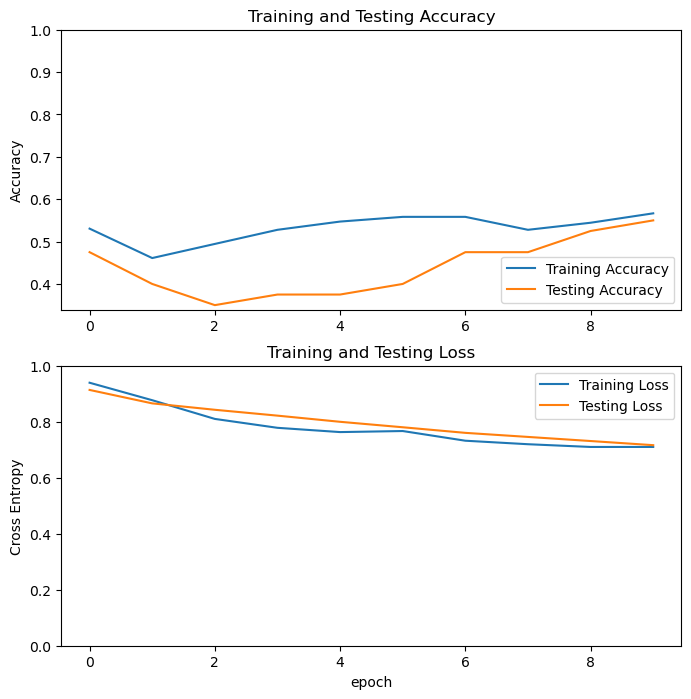

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss_eval, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 78ms/step - loss: 0.7162 - accuracy: 0.5500
Test accuracy : 0.550000011920929


Train the model using weight fine-tuning

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
#unfreeze the base_model
base_model.trainable = True

# take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Compile the model

Training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, the model could overfit very quickly.

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile the model,Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

Continue training the model

In [ ]:

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
#continue training the model
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 10/20
12/12 [==============================] - 12s 643ms/step - loss: 0.6292 - accuracy: 0.6694 - val_loss: 0.5695 - val_accuracy: 0.7500
Epoch 11/20
12/12 [==============================] - 7s 588ms/step - loss: 0.4736 - accuracy: 0.7556 - val_loss: 0.4850 - val_accuracy: 0.7750
Epoch 12/20
12/12 [==============================] - 6s 524ms/step - loss: 0.4620 - accuracy: 0.7806 - val_loss: 0.4325 - val_accuracy: 0.8250
Epoch 13/20
12/12 [==============================] - 6s 513ms/step - loss: 0.4003 - accuracy: 0.8056 - val_loss: 0.6066 - val_accuracy: 0.7500
Epoch 14/20
12/12 [==============================] - 7s 523ms/step - loss: 0.3895 - accuracy: 0.8417 - val_loss: 0.4603 - val_accuracy: 0.8750
Epoch 15/20
12/12 [==============================] - 7s 598ms/step - loss: 0.3526 - accuracy: 0.8583 - val_loss: 0.4366 - val_accuracy: 0.8750
Epoch 16/20
12/12 [==============================] - 7s 568ms/step - loss: 0.3143 - accuracy: 0.8528 - val_loss: 0.3610 - val_accuracy: 0.900

Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 99ms/step - loss: 0.4967 - accuracy: 0.8500
Test accuracy : 0.8500000238418579


Predictions:
 [0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1]
Labels:
 [0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0]


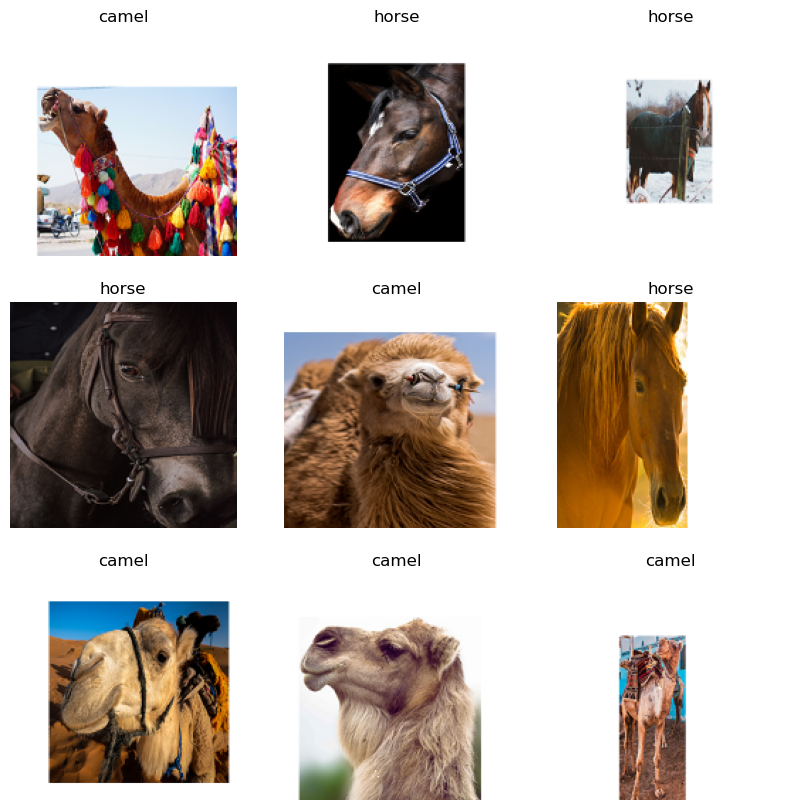

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


Confusion Matrix

[[ 9  6]
 [ 0 17]]


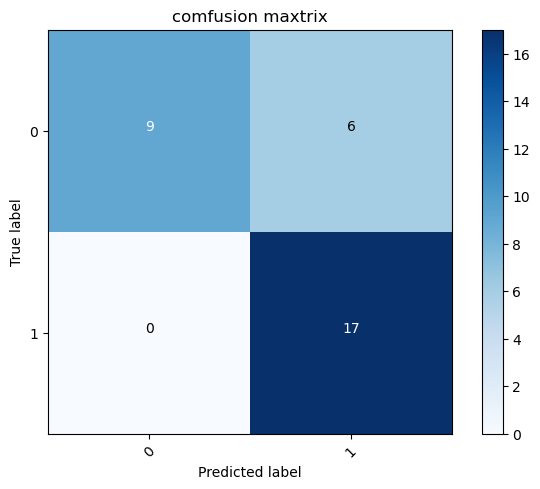

In [ ]:
#Compute confusion matrix to evaluate the accuracy of a classification.
cm = confusion_matrix(y_true=label_batch, y_pred=predictions,labels=[0,1])
print(cm)
classes = ['0','1']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('comfusion maxtrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./confusion_matrix.jpg')

Summary

 In this assignment, to get the training model, only changed the top-level layers of the pre-trained models via fine-tuning, the layers below the top-levl were kept. The accuracy of the training model with fine tuning is better than the pre-trained models, so the trainning model with fine tuning could get better result.